## How many cosmic muons traversing the TPC?

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

How to get the vertical cosmic muon flux, $I_v$, see AnalyticCosmicSpectrum.ipynb.

Then use $I(\theta) = I_v\cos^2\theta$, regardless the momentum, to get the most conservative number of cosmic rays intersecting the TPC.

The TPC dimension (x, y, z) = (50, 60, 60)cm, while z is the vertical coordinate downward for convenience - different from the coordinate system used in the other studies.  The 0 is at the center of the (x, y) plane but the top side of the TPC.  I.e. $x \in [-25, 25]$, $y \in [-30, 30]$, $z \in [0, 60]$ cm.

In [2]:
# momentum range in GeV/c
pmin = 3
pmax = 100000

In [3]:
# Analytical cosmic ray flux from the paper
def dI_fixedTheta(p, theta):
    return 18/(p*np.cos(theta)+145)* (1./np.power((p+2.7/np.cos(theta)), 2.7))* (p+5)/(p+5/np.cos(theta))

In [4]:
# 1-D integral
theta = 0
Iv = integrate.quad(dI_fixedTheta, pmin, pmax, args = (theta))
Iv

(0.0035574258942180173, 1.0291962483084904e-08)

In [2]:
# Normalization factor of the probability density
F = integrate.quad( lambda x: x**2, 0, 1)

In [3]:
# Cosine distribution, cos^2(theta)
def x2(x):
    return x**2/F[0]

In [4]:
# CDF of the x^2 distribution
def cdf(costh):
    return (1.-costh**3)/(3*F[0])

In [5]:
# Inverse CDF of x^2
def inv_cdf(c):
    return np.cbrt(1-3*c*F[0])

In [6]:
def findLineIntersectionPointWithPlane(p0, v, p1, n):
    t = np.dot((p1-p0), n)/np.dot(v, n)
    return p0 + v*t

In [7]:
# test
p0 = np.array([0, -32, -2])
v = np.array([0, 1, 1])
p1 = np.array([0, -30, 0])
n = np.array([0, -1, 0])
x = findLineIntersectionPointWithPlane(p0, v, p1, n)
x

array([  0., -30.,   0.])

In [8]:
# Unit: cm
xHalf = 25.
yHalf = 30.
zFull = 60.
# Define the planes corresponding to the 6 faces by a point and a normal vector
p1s = np.array([[0., 0., 0.], [0., -yHalf,0.], [0., yHalf, 0.], [ -xHalf, 0., 0.], [xHalf, 0., 0.], [0., 0., zFull]])
norms = np.array([[0., 0., -1,], [0., -1., 0.], [0., 1., 0.], [-1., 0., 0.], [1., 0., 0.], [0., 0., 1.]])
# Define the borders of the 6 faces
eps = 1e-6
faces = np.array([[[-xHalf, xHalf], [-yHalf, yHalf], [-eps, eps]], 
                  [[-xHalf, xHalf], [-yHalf-eps, -yHalf+eps], [0., zFull]],
                  [[-xHalf, xHalf], [yHalf-eps, yHalf+eps], [0., zFull]],
                  [[-xHalf-eps, -xHalf+eps], [-yHalf, yHalf], [0., zFull]],
                  [[xHalf-eps, xHalf+eps], [-yHalf, yHalf], [0., zFull]],
                  [[-xHalf, xHalf], [-yHalf, yHalf], [zFull-eps, zFull+eps]]])

In [9]:
def findTraversing(x, face):
    
    if x[0] >= face[0][0] and x[0] <= face[0][1] and \
       x[1] >= face[1][0] and x[1] <= face[1][1] and \
       x[2] >= face[2][0] and x[2] <= face[2][1]:
        return True
    
    return False

In [10]:
# Test
findTraversing(np.array([-24, -30, 2]), faces[1])

True

In [11]:
def genSolidAngle(nSamples):
    uniformCosth = np.random.default_rng().uniform(0, 1, nSamples)
    SolidAngle = np.array([
        [costh, phi]
        for costh, phi in zip(inv_cdf(uniformCosth), np.random.default_rng().uniform(0, 2*np.pi, nSamples))])
    return SolidAngle

In [12]:
def getSinFromCos(costh):
    return np.sqrt(1 - costh**2)

In [13]:
# Unit: cm
# Define where to sample the cosmic muon flux
zPosition = -800
# zPosition = -10
nSolidAngles = 10000

In [14]:
def genXYPosition(xyBound, zPosition, nSteps):
    iStep = np.linspace(0, xyBound, nSteps+1)
    XPosYMin = np.array([[x, -xyBound, zPosition] for x in iStep ])
    XNegYMin = np.array([[x, -xyBound, zPosition] for x in -iStep])
    XPosYMax = np.array([[x, xyBound, zPosition]  for x in iStep ])
    XNegYMax = np.array([[x, xyBound, zPosition]  for x in -iStep])
    XMinYPos = np.array([[-xyBound, y, zPosition] for y in iStep ])
    XMinYNeg = np.array([[-xyBound, y, zPosition] for y in -iStep])
    XMaxYPos = np.array([[xyBound, y, zPosition]  for y in iStep ])
    XMaxYNeg = np.array([[xyBound, y, zPosition]  for y in -iStep])
    XYPosition = np.concatenate(( XPosYMin, XNegYMin, XPosYMax, XNegYMin, XMinYPos, XMinYNeg, XMaxYPos, XMaxYNeg))
    unique_check = np.unique(XYPosition, axis = 1)
    if len(XYPosition) != len(unique_check):
        print(f'{len(unique_check)} unique positions out of {len(XYPosition)} positions!')
    # print(f'{nXYPositions} points of cosmic rays being checked')
    
    return XYPosition

In [15]:
# xyBounds = np.array([10., 20., 30., 40., 50., 100., 500., 1000., 5000. ])
# xyBounds = np.array([10., 100., 500.])
# xyBounds = np.array([7500., 10000,])
xyBounds = np.array([6000., 6500., 7000.])
nBounds = len(xyBounds)
nTraverse = np.zeros(nBounds)
nCounter = np.zeros(nBounds)

for ixyBound in range(nBounds):
    
    xyBound = xyBounds[ixyBound]
    XYPosition = genXYPosition(xyBound, zPosition, round(xyBound))

    for p0 in XYPosition:
        
        SolidAngles = genSolidAngle(nSolidAngles)
    
        for costh, phi in SolidAngles:
    
            # print(f'Cosmic ray {nCounter}')
    
            sinth = getSinFromCos(costh)
            v = np.array([sinth*np.cos(phi), sinth*np.sin(phi), costh])
            # print(f'v = {v}')
    
            for p1, norm, face in zip(p1s, norms, faces):
                x = findLineIntersectionPointWithPlane(p0, v, p1, norm)
                # print(f'x = {x}')
                doTraverse = findTraversing(x, face)
                if (doTraverse):
                    # print(f'It traverses! v = ({v})')
                    nTraverse[ixyBound] += 1
                    break

            nCounter[ixyBound] += 1

    # print(f'At {p0}, {nTraverse[index]} cosmic rays traversing the TPC out of {nCounter[index]}')

In [16]:
nTraverse

array([336., 248., 212.])

In [17]:
nCounter

array([4.8008e+08, 5.2008e+08, 5.6008e+08])

In [18]:
r = np.array([ float(t)/float(c) for t, c in zip(nTraverse, nCounter)])
r

array([6.99883353e-07, 4.76849715e-07, 3.78517355e-07])

In [19]:
result = np.array([ [xyBound, nT, nC, r] for xyBound, nT, nC, r in zip(xyBounds, nTraverse, nCounter, r)])
result

array([[6.00000000e+03, 3.36000000e+02, 4.80080000e+08, 6.99883353e-07],
       [6.50000000e+03, 2.48000000e+02, 5.20080000e+08, 4.76849715e-07],
       [7.00000000e+03, 2.12000000e+02, 5.60080000e+08, 3.78517355e-07]])

In [20]:
with open('nCosmicsInTPC4.npy', 'wb') as f:
    np.save(f, result)

In [2]:
a = np.load('nCosmicsInTPC.npy')
a

array([[1.00000000e+01, 2.08300000e+03, 8.80000000e+05, 2.36704545e-03],
       [2.00000000e+01, 3.67100000e+03, 1.68000000e+06, 2.18511905e-03],
       [3.00000000e+01, 5.47400000e+03, 2.48000000e+06, 2.20725806e-03],
       [4.00000000e+01, 7.57400000e+03, 3.28000000e+06, 2.30914634e-03],
       [5.00000000e+01, 9.42100000e+03, 4.08000000e+06, 2.30906863e-03],
       [1.00000000e+02, 1.92060000e+04, 8.08000000e+06, 2.37698020e-03],
       [5.00000000e+02, 6.22200000e+04, 4.00800000e+07, 1.55239521e-03],
       [1.00000000e+03, 3.52040000e+04, 8.00800000e+07, 4.39610390e-04],
       [2.00000000e+03, 8.11300000e+03, 1.60080000e+08, 5.06809095e-05],
       [3.00000000e+03, 2.59200000e+03, 2.40080000e+08, 1.07964012e-05],
       [4.00000000e+03, 1.15100000e+03, 3.20080000e+08, 3.59597601e-06],
       [5.00000000e+03, 5.95000000e+02, 4.00080000e+08, 1.48720256e-06],
       [6.00000000e+03, 3.36000000e+02, 4.80080000e+08, 6.99883353e-07],
       [6.50000000e+03, 2.48000000e+02, 5.20080000e

In [3]:
a[:,0]

array([   10.,    20.,    30.,    40.,    50.,   100.,   500.,  1000.,
        2000.,  3000.,  4000.,  5000.,  6000.,  6500.,  7000.,  7500.,
        8000.,  9000., 10000.])

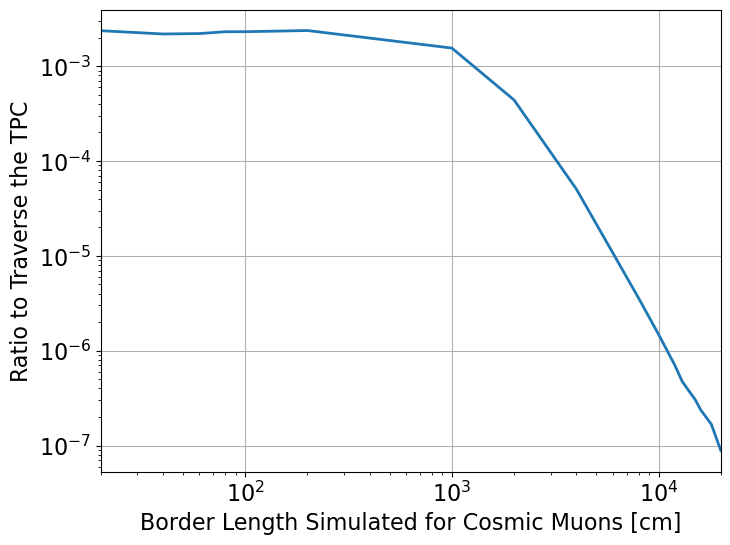

In [4]:
fig, ax = plt.subplots( figsize = (8, 6) )  

ax.plot(a[:,0]*2, a[:,3], lw = 2 )

ax.set_xlabel( r'Border Length Simulated for Cosmic Muons [cm]', fontsize = 16 )
ax.set_ylabel( r'Ratio to Traverse the TPC', fontsize = 16 )
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim( [20, 20000])
# ax.set_ylim( [0, 1.1])

ax.grid(":")
# ax.legend( fontsize = 16 )
fig.savefig('RatioCosmicTraverse.pdf')

In [5]:
# Cosmic ray measured by MicroBooNE: 112Hz/m^2/s
CR = 113
# Event length: 200µs
drift_time = 2*1e-4

In [6]:
# Generate 120mx120m area, with the cosmic ray rate 112 Hz/m^2
# CR*120**2
CR*(120**2)*2*1e-4

325.44

In [7]:
a[:,3]

array([2.36704545e-03, 2.18511905e-03, 2.20725806e-03, 2.30914634e-03,
       2.30906863e-03, 2.37698020e-03, 1.55239521e-03, 4.39610390e-04,
       5.06809095e-05, 1.07964012e-05, 3.59597601e-06, 1.48720256e-06,
       6.99883353e-07, 4.76849715e-07, 3.78517355e-07, 3.08292228e-07,
       2.37470316e-07, 1.68036885e-07, 8.87411259e-08])

In [8]:
ExpCR = CR*(((a[:,0]*2)/100)**2)*drift_time

In [9]:
ExpCR

array([9.0400e-04, 3.6160e-03, 8.1360e-03, 1.4464e-02, 2.2600e-02,
       9.0400e-02, 2.2600e+00, 9.0400e+00, 3.6160e+01, 8.1360e+01,
       1.4464e+02, 2.2600e+02, 3.2544e+02, 3.8194e+02, 4.4296e+02,
       5.0850e+02, 5.7856e+02, 7.3224e+02, 9.0400e+02])

In [10]:
a[:,0]*2

array([   20.,    40.,    60.,    80.,   100.,   200.,  1000.,  2000.,
        4000.,  6000.,  8000., 10000., 12000., 13000., 14000., 15000.,
       16000., 18000., 20000.])

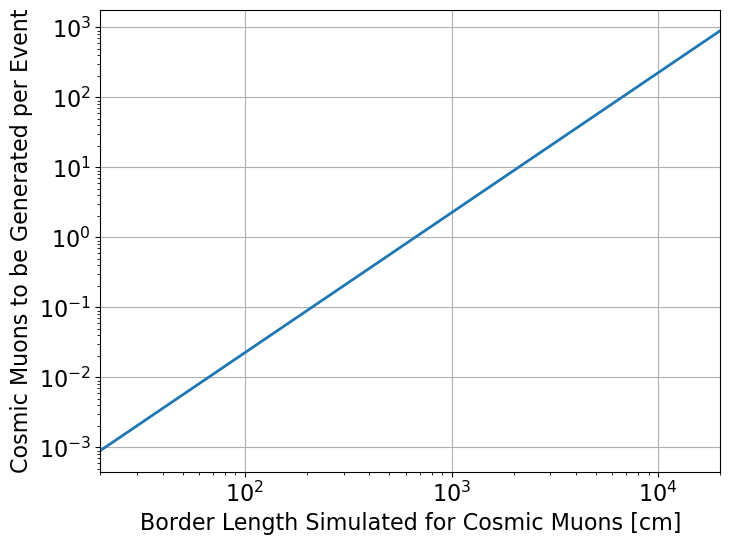

In [11]:
fig, ax = plt.subplots( figsize = (8, 6) )  

ax.plot(a[:,0]*2, ExpCR, lw = 2 )

ax.set_xlabel( r'Border Length Simulated for Cosmic Muons [cm]', fontsize = 16 )
ax.set_ylabel( r'Cosmic Muons to be Generated per Event', fontsize = 16 )
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim( [20, 20000])

ax.grid(":")

In [12]:
ExpCR[8]

36.160000000000004

### Conclusion

Generate 40mx40m (corresponding to 20m in the npy file, since in the npy file it is the half border), totally 36 cosmic muons in an event (200µs).

In [14]:
# How many cosmic rays in 3 years of beam events?
# 60Hz, 5000 hours/year
ExpCR[8]*60*60*24*5000*3

46863360000.000015